In [130]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed


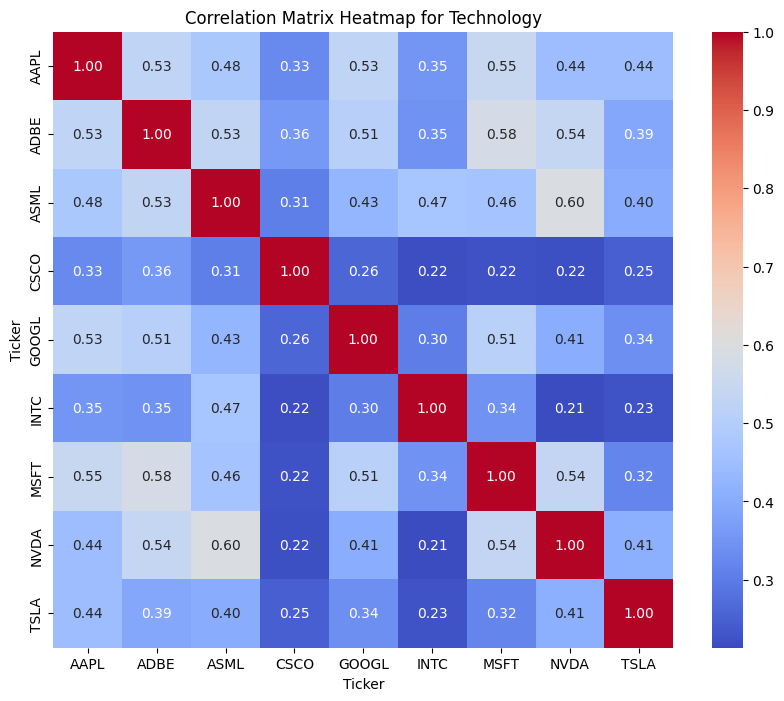


High correlation pairs in Technology: []


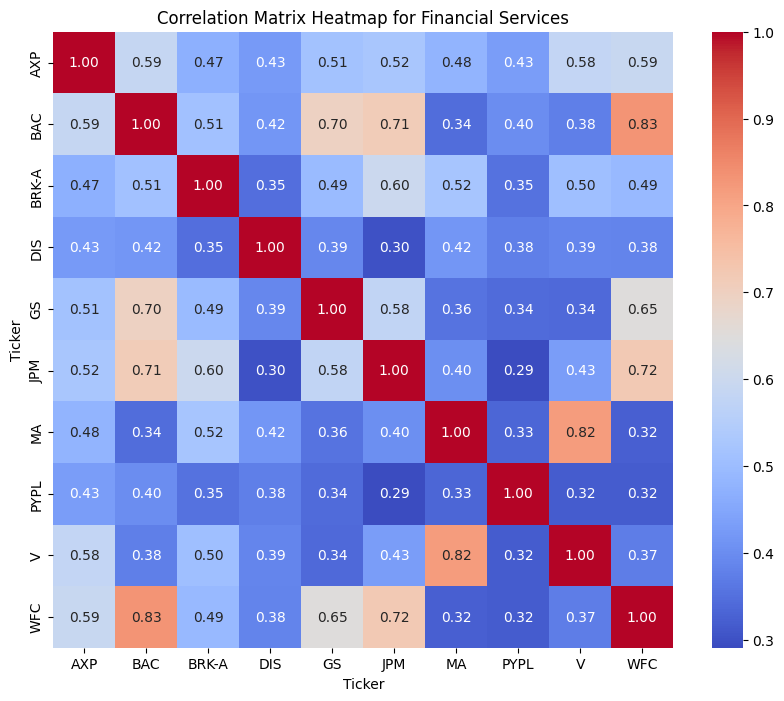


High correlation pairs in Financial Services: [('BAC', 'WFC'), ('MA', 'V')]


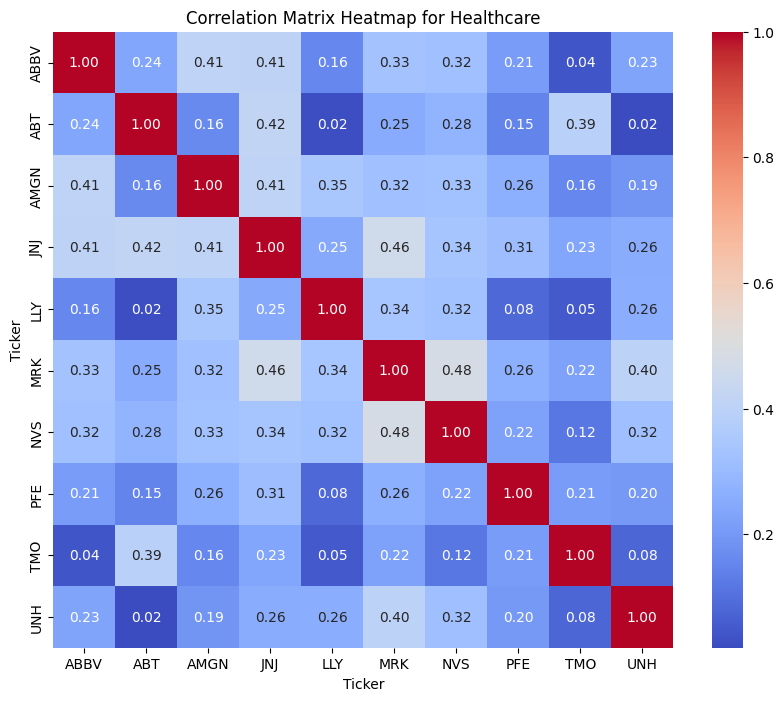


High correlation pairs in Healthcare: []


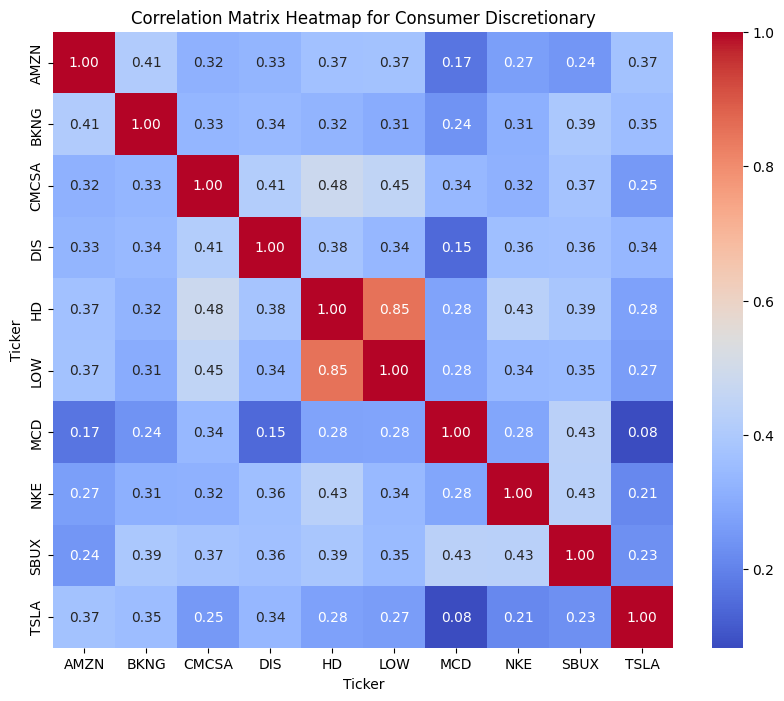


High correlation pairs in Consumer Discretionary: [('HD', 'LOW')]


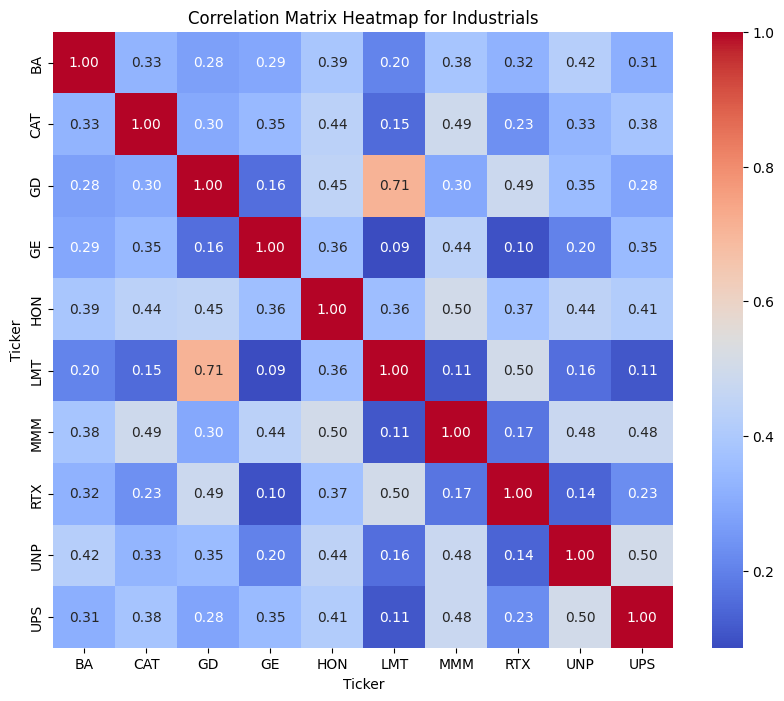


High correlation pairs in Industrials: []


In [131]:
# Define the top stocks in each sector
sectors = {
    'Technology': ['AAPL', 'MSFT', 'GOOGL', 'AAPL', 'TSLA', 'NVDA', 'ADBE', 'INTC', 'CSCO', 'ASML'],
    'Financial Services': ['JPM', 'BRK-A', 'V', 'MA', 'WFC', 'BAC', 'DIS', 'PYPL', 'GS', 'AXP'],
    'Healthcare': ['JNJ', 'UNH', 'MRK', 'PFE', 'ABT', 'NVS', 'TMO', 'LLY', 'AMGN', 'ABBV'],
    'Consumer Discretionary': ['AMZN', 'HD', 'MCD', 'NKE', 'SBUX', 'CMCSA', 'TSLA', 'DIS', 'LOW', 'BKNG'],
    'Industrials': ['MMM', 'HON', 'UNP', 'UPS', 'CAT', 'BA', 'RTX', 'LMT', 'GD', 'GE']
}

# Fetch historical stock price data
stock_data = {}
for sector, stocks in sectors.items():
    stock_data[sector] = yf.download(stocks, start='2023-01-01', end='2023-12-31')['Adj Close']

# Calculate daily returns
returns = {}
for sector, data in stock_data.items():
    returns[sector] = data.pct_change().dropna()

# Compute the correlation matrix for each sector
correlation_matrices = {}
for sector, returns_data in returns.items():
    correlation_matrices[sector] = returns_data.corr()

# Visualize the correlation matrices as heatmaps
for sector, correlation_matrix in correlation_matrices.items():
    # Create a heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Correlation Matrix Heatmap for {sector}')
    plt.show()
    print()
    
# Print pairs with correlation > 0.8
    high_correlation_pairs = [(stock1, stock2) for stock1 in correlation_matrix.columns for stock2 in correlation_matrix.columns if stock1 < stock2 and correlation_matrix.loc[stock1, stock2] > 0.8]
    print(f'High correlation pairs in {sector}: {high_correlation_pairs}')

In [132]:
# Identify pairs with correlation > 0.8
cointegration_pairs = {}
for sector, corr_matrix in correlation_matrices.items():
    pairs = []
    for stock1 in corr_matrix.columns:
        for stock2 in corr_matrix.columns:
            if stock1 != stock2 and corr_matrix[stock1][stock2] > 0.8:
                pairs.append((stock1, stock2))
    cointegration_pairs[sector] = pairs

# Conduct cointegration tests for the identified pairs
results = {}
for sector, pairs in cointegration_pairs.items():
    results[sector] = {}
    for stock1, stock2 in pairs:
        score, p_value, critical_values = sm.tsa.stattools.coint(returns[sector][stock1], returns[sector][stock2])
        results[sector][(stock1, stock2)] = {
            'Score': score,
            'p-value': p_value,
            'Cointegrated': p_value < 0.05  # 5% significance level
        }

# Display the results
for sector, tests in results.items():
    print(f'\nCointegration Results for {sector}:')
    for pair, result in tests.items():
        print(f'{pair}: Score = {result["Score"]:.4f}, p-value = {result["p-value"]:.4f}, Cointegrated = {result["Cointegrated"]}')


Cointegration Results for Technology:

Cointegration Results for Financial Services:
('BAC', 'WFC'): Score = -12.3527, p-value = 0.0000, Cointegrated = True
('MA', 'V'): Score = -15.8747, p-value = 0.0000, Cointegrated = True
('V', 'MA'): Score = -15.6245, p-value = 0.0000, Cointegrated = True
('WFC', 'BAC'): Score = -17.8748, p-value = 0.0000, Cointegrated = True

Cointegration Results for Healthcare:

Cointegration Results for Consumer Discretionary:
('HD', 'LOW'): Score = -15.8091, p-value = 0.0000, Cointegrated = True
('LOW', 'HD'): Score = -12.2249, p-value = 0.0000, Cointegrated = True

Cointegration Results for Industrials:


[*********************100%%**********************]  6 of 6 completed


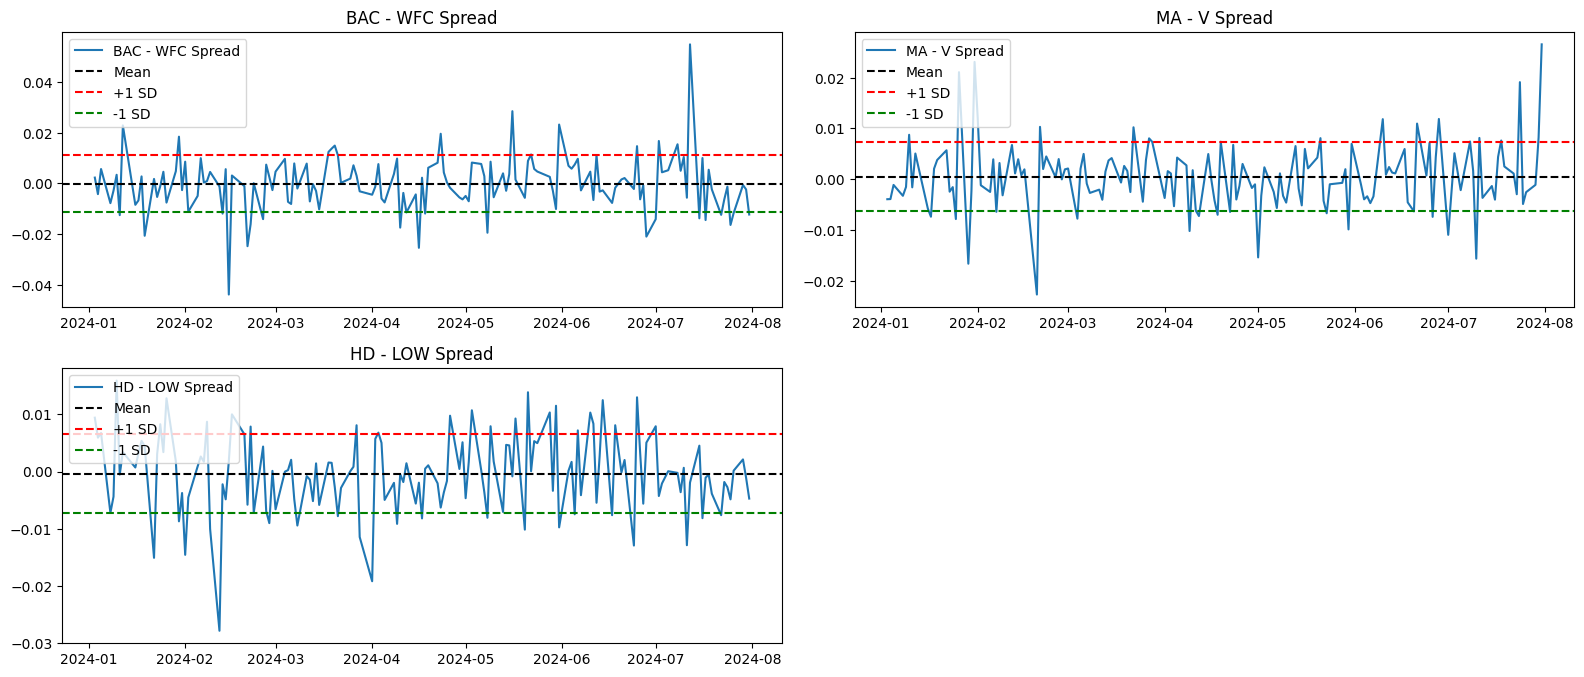

In [133]:
# Selected pairs with correlation > 0.8
selected_pairs = ['BAC', 'WFC', 'MA', 'V', 'HD', 'LOW']

# Fetch historical stock price data for the selected pairs
stock_data = yf.download(selected_pairs, start='2024-01-01', end='2024-08-01')['Adj Close']

# Calculate daily returns
returns = stock_data.pct_change().dropna()

# Calculate spread for each pair
spread_data = {}
for i in range(0, len(selected_pairs), 2):
    pair = (selected_pairs[i], selected_pairs[i+1])
    stock1, stock2 = pair
    spread = returns[stock1] - returns[stock2]
    spread_data[pair] = spread

# Compute mean and standard deviation of each spread
spread_stats = {}
for pair, spread in spread_data.items():
    mean_spread = spread.mean()
    std_spread = spread.std()
    spread_stats[pair] = (mean_spread, std_spread)

# Trading strategy
threshold = 1  # Standard deviation threshold
trade_signals = {}
for pair, spread in spread_data.items():
    mean_spread, std_spread = spread_stats[pair]
    upper_threshold = mean_spread + threshold * std_spread
    lower_threshold = mean_spread - threshold * std_spread
    long_entries = spread[spread >= upper_threshold]
    short_entries = spread[spread <= lower_threshold]
    trade_signals[pair] = (long_entries, short_entries)

# Plot the spread of selected pairs 
plt.figure(figsize=(16, 10))  # Increase figure size
for i, (pair, spread) in enumerate(spread_data.items(), 1):
    plt.subplot(len(selected_pairs)//2, 2, i)
    plt.plot(spread.index, spread, label=f'{pair[0]} - {pair[1]} Spread')
    plt.axhline(spread_stats[pair][0], color='k', linestyle='--', label='Mean')
    plt.axhline(spread_stats[pair][0] + threshold * spread_stats[pair][1], color='r', linestyle='--', label='+1 SD')
    plt.axhline(spread_stats[pair][0] - threshold * spread_stats[pair][1], color='g', linestyle='--', label='-1 SD')
    plt.legend(loc='upper left')  # Adjust legend position
    plt.title(f'{pair[0]} - {pair[1]} Spread')
plt.tight_layout()
plt.show()

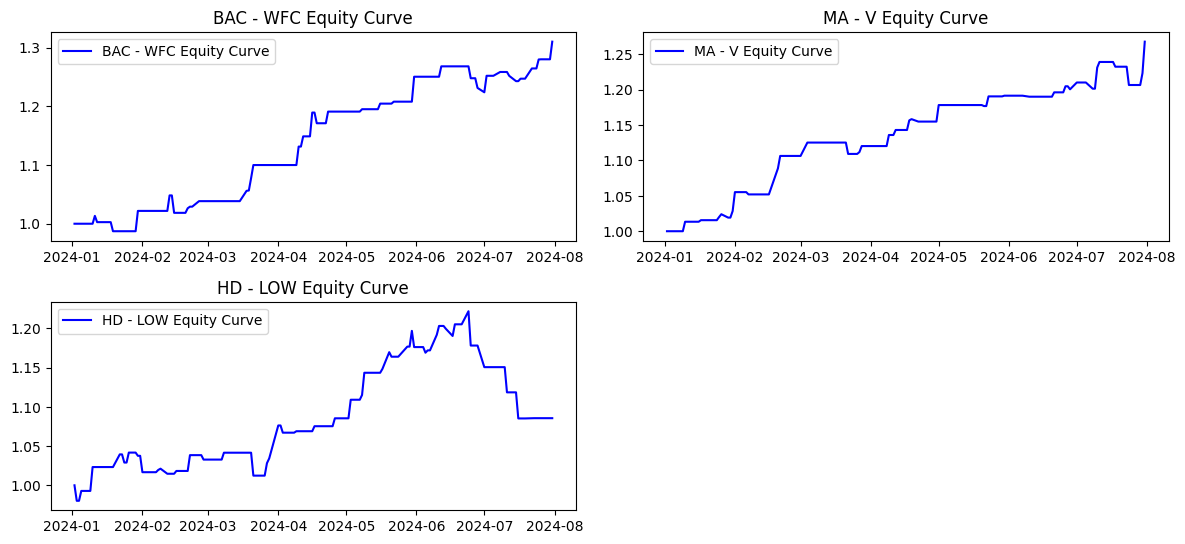

[*********************100%%**********************]  1 of 1 completed

BAC - WFC Percentage Return: 31.06%
MA - V Percentage Return: 26.80%
HD - LOW Percentage Return: 8.56%
Portfolio Return with Equal Weights (Average of Pair Returns): 22.14%
S&P 500 Total Return: 16.43%


In [134]:
# Simulate trading and create equity curves
equity_curves = {}
for pair, (long_entries, short_entries) in trade_signals.items():
    equity_curve = pd.Series(index=stock_data.index)
    equity_curve.iloc[0] = 1.0  # Starting equity
    for date in stock_data.index[1:]:
        if date in long_entries.index:
            equity_curve.loc[date] = equity_curve.shift(1).loc[date] * (1 + returns[pair[0]].loc[date])
        elif date in short_entries.index:
            equity_curve.loc[date] = equity_curve.shift(1).loc[date] * (1 - returns[pair[0]].loc[date])
        else:
            equity_curve.loc[date] = equity_curve.shift(1).loc[date]
    equity_curves[pair] = equity_curve

# Plot the equity curves for each pair
plt.figure(figsize=(12, 8))
for i, (pair, equity_curve) in enumerate(equity_curves.items(), 1):
    plt.subplot(len(selected_pairs)//2, 2, i)
    plt.plot(equity_curve.index, equity_curve, label=f'{pair[0]} - {pair[1]} Equity Curve', color='b')
    plt.legend()
    plt.title(f'{pair[0]} - {pair[1]} Equity Curve')
plt.tight_layout()
plt.show()
plt.show()

# Calculate percentage return of each pair
pair_returns = {}
for pair, equity_curve in equity_curves.items():
    pair_return = (equity_curve.iloc[-1] - 1) * 100  # Calculate percentage return
    pair_returns[pair] = pair_return
    print(f'{pair[0]} - {pair[1]} Percentage Return: {pair_return:.2f}%')

average_return = np.mean(list(pair_returns.values()))

# Calculate the total return of equal weight portfolio
portfolio_return = average_return
print(f'Portfolio Return with Equal Weights (Average of Pair Returns): {portfolio_return:.2f}%')

# Fetch historical data for the S&P 500 index
sp500_data = yf.download('^GSPC', start='2024-01-01', end='2024-08-01')['Adj Close']

# Calculate daily returns
sp500_returns = sp500_data.pct_change().dropna()

# Calculate total S&P500 return over the same period
total_return = (sp500_data.iloc[-1] / sp500_data.iloc[0] - 1) * 100

print(f'S&P 500 Total Return: {total_return:.2f}%')